# ***Pre-Entrega Proyecto Final***

## Descripcion del proyecto

### Modelo de negocio

El proyecto aborda un modelo de negocio de hospedaje en una zona de turismo europea. Este hotel exclusivo se distingue por ofrecer una experiencia de alojamiento de alta calidad, basada en la excelencia de sus servicios y la comodidad de sus instalaciones.<br>El modelo de negocio se sustenta en la diversificación de fuentes de ingresos, que van más allá de la simple renta de habitaciones. Esto incluye la organización de eventos corporativos, bodas y celebraciones especiales, así como la oferta de paquetes turísticos completos que incluyen alojamiento, transporte y actividades recreativas.

### Problematica

La gerencia del hotel observa en el periodo que comprende desde mediados del año 2017 hasta finales del 2018 una sólida presencia de reservas canceladas, lo que implica una perdida de nuevos clientes y de potenciales reservas efectivas. 
Desde el área de toma de decisiones se deniega la posibilidad de cobrar un monto, a modo de garantia, por la reserva de los servicios contratados, ya que esto genera un gasto inmediato para el cliente al momento de planificar su viaje, por este motivo la empresa acude a nuestro de servicio de análisis de datos a fines de poder detectar cuales son las reservas que son candidatas a ser canceladas.

### Hipotesis

Considerando el modelo de negocio planteado y su desafío de predecir cancelaciones de reservas, se propone la siguiente hipótesis: ***Existe un conjunto de variables que pueden ser identificadas y ponderadas para predecir con precisión qué reservas serán canceladas***. Esta investigación se centrará en identificar qué variables tienen mayor influencia en la probabilidad de cancelación de una reserva. A través del análisis de estas variables y su impacto en la cancelación de reservas, se plantearán preguntas como: ***¿Qué factores específicos contribuyen significativamente a la probabilidad de cancelación?*** ***¿Cómo pueden estas variables ser utilizadas para desarrollar un modelo predictivo robusto?*** Al responder estas preguntas, se espera obtener información crucial para la toma de decisiones.

### Diccionario de datos

- Booking_ID: Identificador único de registro
- num_adults: Número de adultos en la reserva
- num_children: Número de niños en la reserva
- weekend_nights: Número de noches de semana reservados
- week_nights: Número de noches de fin de semana reservados
- meal_plan: Plan de comida seleccionado
- car_parking: Solicitud de espacio de estacionamiento (0=No; 1=Si)
- room_type: Tipo de habitación seleccionada en la reserva
- lead_time: Número de días de anticipación con que se realiza la reserva
- arrival_year: Año de la fecha de arribo al hotel
- arrival_month: Mes de la fecha de arribo al hotel
- arrival_date: Dia de la fecha de arribo al hotel
- mkt_segment: Medio por el cual se realiza la reserva
- repeated_guest: Si el cliente es un cliente regular (0=No; 1=Si)
- num_prev_cancellations: Número de reservas canceladas previamente
- num_prev_not_canceled: Número de reservas no canceladas previamente
- avg_price_room: Precio promedio de la habitación seleccionada en la reserva
- num_sp_requests: Número de solicitudes extra en la reserva
- booking_status: Estado de la reserva (No cancelada/Cancelada)

## Librerias y Funciones

In [1]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [2]:
#FUNCION PARA COMPARAR DENSIDAD DE DISTRIBUCIONES ANTES Y DESPUES DE IMPUTAR
def comparison_dist(data_1:pd.Series, data_2:pd.Series, action:str, x_label:str, fig_size:tuple):
    plt.style.use("bmh")    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=fig_size)

    #GRAFICO 1
    sns.kdeplot(x=data_1, ax=ax[0])
    ax[0].set_title('Distribucion original')
    ax[0].set_xlabel(x_label)

    #GRAFICO 2
    sns.kdeplot(data=data_2, ax=ax[1])
    ax[1].set_xlabel(x_label)
    ax[1].set_title(f'Distribucion despues de {action}') #ACTION(IMPUTAR, ELIMINAR)

    #PLOTEO
    plt.tight_layout()
    plt.show()
    plt.style.use("default")

In [3]:
#FUNCION DE TRANSFORMACION PARA VARIABLES CUALITATIVAS ORDINALES
def get_ordinal_var(category:str):
    if re.search(r'^\D+$', category): return '0'
    if re.search(r'.*1$', category): return '1'
    if re.search(r'.*2$', category): return '2'
    if re.search(r'.*3$', category): return '3'
    if re.search(r'.*4$', category): return '4'
    if re.search(r'.*5$', category): return '5'
    if re.search(r'.*6$', category): return '6'
    if re.search(r'.*7$', category): return '7'

In [4]:
#CLASE PARA PLOTEOS DE CORRELACIONES
class PlotCorrelation():
    def __init__(self, df:pd.DataFrame, target_var:str, vars:list, vars_type:str):
        self.df = df
        self.target_var = target_var
        self.vars = vars
        self.vars_type = vars_type

    #CREA UN DATAFRAME VACIO PARA ALOJAR LAS CORRELACIONES
    def _get_correlation_dataframe(self) -> pd.DataFrame:
        df_corr = pd.DataFrame(index=self.vars, columns=['correlation'])
        return df_corr    

    #DEVUELVE EL NUMERO MULTIPLO DE 10 SUPERIOR INMEDIATO AL VALOR MAXIMO DE LA SERIE
    def _get_limit_value(self, values:pd.Series) -> float:
        limit_value = values.abs().round(2).max()
        limit_value = np.ceil(limit_value*10)/10
        return limit_value

    #FUNCION PARA PLOTEAR CORRELACION DE PUNTO BISERIAL
    def plot_biserial_point(self):
        df_corr = self._get_correlation_dataframe()
        corr_list = [stats.pointbiserialr(self.df[self.target_var], self.df[var]) for var in self.vars]
        for var, corr in zip(self.vars, corr_list):
            df_corr.loc[var, 'correlation'] = corr.statistic
        self._plot_correlation(df_corr)

    #FUNCION PARA PLOTEAR COEFICIENTE DE CONTIGENCIA
    def plot_coef_contingency(self):
        df_corr = self._get_correlation_dataframe()
        for var in self.vars:
            contingency_table = pd.crosstab(self.df[var], self.df[self.target_var])
            chi_2 = stats.chi2_contingency(contingency_table)
            df_corr.loc[var, 'correlation'] = math.sqrt(chi_2.statistic/(self.df.shape[0]+chi_2.statistic))
        self._plot_correlation(df_corr)

    #FUNCION PARA PLOTEAR EL GRAFICO DE BARRAS
    def _plot_correlation(self, df_corr:pd.DataFrame):
        colors = ['#000E9E' if corr < 0 else '#3DB2DA' for corr in df_corr.correlation]
        limit_value = self._get_limit_value(df_corr.correlation)
        plt.style.use("bmh")
        plt.figure(figsize=(8,5))  
        sns.barplot(x=df_corr.correlation, y=df_corr.index, hue=df_corr.index, palette=colors)
        plt.title(f'Correlacion de variable objetivo con variables {self.vars_type}', fontsize=14)
        plt.xlabel('Coeficiente de correlacion')
        plt.ylabel(f'Variables {self.vars_type}')
        plt.xlim(-1*limit_value, limit_value)
        plt.axvline(x=0, color='black', linestyle='-')
        plt.tight_layout()
        plt.show()
        plt.style.use("default")  

## Conociendo los datos

### Exploracion del dataset

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/arielRas/DataSets/main/Hotel_Reservations.csv')
df.head(3)

,Booking_ID,num_adults,num_children,weekend_nights,week_nights,meal_plan,car_parking,room_type,lead_time,arrival_year,arrival_month,arrival_date,mkt_segment,repeated_guest,num_prev_cancellations,num_prev_not_canceled,avg_price_room,num_sp_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled


In [6]:
print(f'La cantidad de filas y columnas es: {df.shape}\n\n')
df.info()

La cantidad de filas y columnas es: (36275, 19)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Booking_ID              36275 non-null  object 
 1   num_adults              36275 non-null  int64  
 2   num_children            36275 non-null  int64  
 3   weekend_nights          36275 non-null  int64  
 4   week_nights             36275 non-null  int64  
 5   meal_plan               36275 non-null  object 
 6   car_parking             36275 non-null  int64  
 7   room_type               36275 non-null  object 
 8   lead_time               36275 non-null  int64  
 9   arrival_year            36275 non-null  int64  
 10  arrival_month           36275 non-null  int64  
 11  arrival_date            36275 non-null  int64  
 12  mkt_segment             36275 non-null  object 
 13  repeated_guest          36275 non-null  i

In [7]:
df.describe()

,num_adults,num_children,weekend_nights,week_nights,car_parking,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,num_prev_cancellations,num_prev_not_canceled,avg_price_room,num_sp_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


## Data Wrangling

### Variable ***num_adults***

Esta variable describe la cantidad de personas adultas que componen la reserva y que se alojaran en el hotel. Se puede divisar con el metodo ***describe()*** en la celda posterior que el valor minimo de la variable es cero y segun las reglas de negocio de este hotel, en las reservas debe haber al menos un adulto (>= 18 años) por reserva, los menores no pueden reservar por si solos. En el caso de que la reserva solo tenga menores, se interpreta el dato como erroneo.

In [8]:
df.num_adults.describe()

count    36275.000000
mean         1.844962
std          0.518715
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: num_adults, dtype: float64

In [9]:
#CANTIDAD DE RESERVAS SIN ADULTOS
print(f'La cantidad de reservas sin adultos es: {df.loc[df.num_adults < 1].shape[0]}')

La cantidad de reservas sin adultos es: 139


In [10]:
#Se eliminan las reservas y se verifica
df = df.loc[df.num_adults >= 1]
print(f'La cantidad de reservas sin adultos despues de la modificacion es: {df.loc[df.num_adults < 1].shape[0]}')

#Se imprime informacion del dataframe despues de eliminar registros
print(f'La cantidad de filas y columnas del dataframe despues de la modificacion es: {df.shape}')

La cantidad de reservas sin adultos despues de la modificacion es: 0
La cantidad de filas y columnas del dataframe despues de la modificacion es: (36136, 19)


### Variable ***num_children***

Esta variable describe la cantidad de niños menores que componen la reserva y que se alojaran en el hotel. Se puede divisar con el metodo ***describe()*** en la celda posterior, que la variable muestra el valor **cero** para el tercer cuartil, lo que da la pauta de que en el 75% de los datos en esta variable es cero y su valor maximo es 10, como el valor maximo se aleja bastante del 3er cuartil, veremos si este valor es un outlier.

In [11]:
df.num_children.describe()

count    36136.000000
mean         0.097880
std          0.385097
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: num_children, dtype: float64

In [12]:
for item in range(0,11):
    print(f'La cantidad de reservas con {item} niños es: {df.loc[df.num_children == item].shape[0]}')

La cantidad de reservas con 0 niños es: 33577
La cantidad de reservas con 1 niños es: 1617
La cantidad de reservas con 2 niños es: 925
La cantidad de reservas con 3 niños es: 14
La cantidad de reservas con 4 niños es: 0
La cantidad de reservas con 5 niños es: 0
La cantidad de reservas con 6 niños es: 0
La cantidad de reservas con 7 niños es: 0
La cantidad de reservas con 8 niños es: 0
La cantidad de reservas con 9 niños es: 2
La cantidad de reservas con 10 niños es: 1


Como se puede observar hay valores atipicos que se alejan fuertemente de los datos, debido a la poca significancia cuantitativa de estos datos atipicos, se decide eliminar las observaciones que los contienen.

In [13]:
#SIGNIFICANCIA PORCENTUAL DE LOS DATOS A ELIMINAR
perc = (df.loc[df.num_children >3].shape[0]/df.shape[0])*100
print(f'Los datos a eliminar representan el {perc:.3f}% de los datos')

#SE ELIMINAN DATOS AOUTLIERS
df = df.loc[df.num_children <= 3]

Los datos a eliminar representan el 0.008% de los datos


In [14]:
df.num_children.describe()

count    36133.000000
mean         0.097113
std          0.375780
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: num_children, dtype: float64

### Variables ***weekend_nights*** y ***week_nights***

Estas variables describen la cantidad de dias de fin de semana y dias de semana respectivamente por la cual se reserva la habitacion del hotel. A partir de esto se generará una nueva variable que describa la cantidad de dias totales por la cual se reseva.

In [15]:
#SE CREA DATAFRAME ADICIONAL PARA CREAR NUEVA VARIABLE
booking_nights = df[['weekend_nights','week_nights']].copy()

#SE CREA NUEVA VARIABLE EN BASE A LAS EXISTENTES
booking_nights.loc[:,'total_nights'] = booking_nights.apply(lambda x: x.weekend_nights + x.week_nights, axis=1)

#INFORMACION DE LA NUEVA VARIABLE
booking_nights.total_nights.describe()

count    36133.000000
mean         3.013782
std          1.785856
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         24.000000
Name: total_nights, dtype: float64

En la informacion que se muestra de la nueva variable se puede observar que el valor minimo en ella es **cero**, lo cual no seria valido. Por este motivo es que se realizara un analisis para aplicar alguna tecnica de imputacion para los valores atipicos mencionados.

In [16]:
#MEDIDAS DE TENDENCIA CENTRAL DE LA VARIABLE
print(f'Media: {booking_nights.total_nights.mean()}')
print(f'Mediana: {booking_nights.total_nights.median()}')
print(f'Moda: {stats.mode(booking_nights.total_nights)[0]}')

#MEDIDAS DE DISPERSION
print(f'Coef asimetria: {booking_nights.total_nights.skew()}')
print(f'Kurtosis: {booking_nights.total_nights.kurtosis()}')

Media: 3.013782414966928
Mediana: 3.0
Moda: 3
Coef asimetria: 2.235381600158218
Kurtosis: 12.25874810112899


In [17]:
#IMPUTACION DE DATOS ATIPICOS
booking_nights.loc[booking_nights.total_nights == 0, 'total_nights'] = booking_nights.total_nights.median()

#MEDIDAS DE DISPERSION
print(f'Coef asimetria: {booking_nights.total_nights.skew()}')
print(f'Kurtosis: {booking_nights.total_nights.kurtosis()}')

Coef asimetria: 2.2557593832576317
Kurtosis: 12.397887471427797


Como se observa en los coeficientes de dispersion, la imputacion por la **mediana** no ha impactado de manera violenta en la distribucion de la variable, es por ello que se conserva este cambio. Ahora solo queda por unir esta nueva variable al **Dataframe** principal.

In [18]:
#SE INSERTA LA NUEVA VARIABLE AL DATAFRAME PRINCIPAL
position = df.columns.get_loc('week_nights')+1
df.insert(column='total_nights', loc=position, value=booking_nights.total_nights)

#SE LIBERAN RECURSOS
del booking_nights

#INFORMACION
df.total_nights.describe()

count    36133.000000
mean         3.020258
std          1.780346
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         24.000000
Name: total_nights, dtype: float64

### Variables ***arrival_year***, ***arrival_month*** y ***arrival_date***

Estas variables describen el año, mes y dia de arribo respectivamente. Lo que se hara en esta seccion es crear una variable especifica para describir la fecha y con esta informacion obtener la estacion del año para la cual se realizo la reserva

In [19]:
#PRiMERO SE REALIZARA UN CAMBIO DE NOMBRE A FINES DE EVITAR AMBIGUEDAD
df.rename(columns={'arrival_date':'arrival_day'}, inplace=True)

#SE CREA DATAFRAME COMPLEMETARIO PARA RELIZAR LOS CAMBIOS
dates = df[['arrival_year','arrival_month', 'arrival_day']].copy()
dates.columns = ['y','m','d']

#SE GENERA LA NUEVA VARIABLE
dates.loc[:,'arrival_date'] = dates.apply(lambda x: str(x.y) + '-' + str(x.m) + '-' + str(x.d), axis=1)
dates.head(3)

,y,m,d,arrival_date
0,2017,10,2,2017-10-2
1,2018,11,6,2018-11-6
2,2018,2,28,2018-2-28


Si bien ya se ha obtenido la columna de fecha, esta tiene un tipo de dato ***str***, lo cual no es nuestro objetivo. Por ello se transformaran estos datos a tipo ***Datetime*** lo que va a generar algunos datos nulos que manejaremos posteriormente

In [20]:
#SE CONVIERTE LA VARIABLE ARRIVAL_DATE EN DATETIME
dates.arrival_date = pd.to_datetime(dates.arrival_date, format="%Y-%m-%d",yearfirst=True, errors='coerce')
dates.arrival_date.info()

<class 'pandas.core.series.Series'>
Index: 36133 entries, 0 to 36274
Series name: arrival_date
Non-Null Count  Dtype         
--------------  -----         
36096 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 564.6 KB


In [21]:
#OBSERVACION DE DATOS NULOS
dates.loc[dates.arrival_date.isna()].head(3)

,y,m,d,arrival_date
2626,2018,2,29,NaT
3677,2018,2,29,NaT
5600,2018,2,29,NaT


Como se puede observar los datos ***NaN*** que se generaron al convertir de ***string*** a ***datetime*** fueron producidos por la fecha ***2018-02-29*** una fecha correspondiente a un año biciesto, pero justamente el año 2018 no lo fue. Para este caso en particular reemplazaremos las fechas conflictivas con la fecha del dia anterior.

In [22]:
#CORRECCION DEL ERROR
condition = (dates.y == 2018) & (dates.m == 2) & (dates.d == 29)
dates.loc[condition, 'd'] = 28

#CONVERSION DE TIPO
dates.loc[dates.arrival_date.isna(), 'arrival_date'] = dates.apply(lambda x: pd.to_datetime(str(x.y) + '-' + str(x.m) + '-' + str(x.d), format="%Y-%m-%d",yearfirst=True), axis=1)

#INFORMACION
dates.arrival_date.info()

<class 'pandas.core.series.Series'>
Index: 36133 entries, 0 to 36274
Series name: arrival_date
Non-Null Count  Dtype         
--------------  -----         
36133 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.6 MB


#### Variable ***arrival season***

Como se mencion anteriormente, se dara lugar a la creacion de esta variable, que refiere la estacion del año para la cual se realiza la reserva.

In [23]:
#CREANDO ESTACIONES DEL AÑO (EUROPA)

#SE CREAN VARIABLES CONDICIONALES
is_summer = ((dates.m == 6) & (dates.d >= 21) | (dates.m == 7) | (dates.d == 8) | (dates.m == 9) & (dates.d <= 22))
is_autumn = ((dates.m == 9) & (dates.d >= 23) | (dates.m == 10) | (dates.d == 11) | (dates.m == 12) & (dates.d <= 20))
is_winter = ((dates.m== 12) & (dates.d >= 21) | (dates.m == 1) | (dates.d == 2) | (dates.m == 3) & (dates.d <= 20))

#SE CREA NUEVA VARIABLE
dates["arrival_season"] = "spring"
dates.loc[is_summer, "arrival_season"] = "summer"
dates.loc[is_autumn, "arrival_season"] = "autumn"
dates.loc[is_winter, "arrival_season"] = "winter"

dates.head(3)

,y,m,d,arrival_date,arrival_season
0,2017,10,2,2017-10-02,winter
1,2018,11,6,2018-11-06,spring
2,2018,2,28,2018-02-28,spring


Con el objetivo logrado parcialmente, ahora es momento de deshacerse de las columnas que no nos sirven en del dataframe principal y agregar las nuevas columnas que se consiguieron

In [24]:
#SE IGUALAN LAS COLUMNAS DEL DATAFRAME PRINCIPAL CON EL COMPLEMENTARIO DE LIBRE DE ERRORES
df.arrival_month = dates.m
df.arrival_day = dates.d

#SE INSERTA LA VARIABLE NUEVA EN EL DATRAFRAME PRINCIPAL
position = df.columns.get_loc('arrival_day')+1
df.insert(column='arrival_season', loc=position, value=dates.arrival_season)

#SE LIBERAN RECURSOS
del dates

df.head(3)

,Booking_ID,num_adults,num_children,weekend_nights,week_nights,total_nights,meal_plan,car_parking,room_type,lead_time,...,arrival_month,arrival_day,arrival_season,mkt_segment,repeated_guest,num_prev_cancellations,num_prev_not_canceled,avg_price_room,num_sp_requests,booking_status
0,INN00001,2,0,1,2,3,Meal Plan 1,0,Room_Type 1,224,...,10,2,winter,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,5,Not Selected,0,Room_Type 1,5,...,11,6,spring,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,3,Meal Plan 1,0,Room_Type 1,1,...,2,28,spring,Online,0,0,0,60.00,0,Canceled


### Variable ***avg_price_room***

Esta variable describe el precio promedio en euros de la habitacion rentada. El metodo ***describe()*** en la celda posterior, muestra el valor ***cero*** como minimo de la variable, lo cual no tiene sentido para este caso. Tambien se observa un valor maximo que se despega bastante del 3er cuartil lo cual puede que sea un indicio de la presencia de valores atipicos. En esta seccion se evaluaran los casos mencionados y la forma en que estos seran tratados.

In [25]:
df.avg_price_room.describe()

count    36133.000000
mean       103.509164
std         35.062636
min          0.000000
25%         80.390000
50%         99.480000
75%        120.120000
max        540.000000
Name: avg_price_room, dtype: float64

In [26]:
for i in [179,200,250,300]:
    print(f'La cantidad de observaciones con valor mayor a {i} es de: {df.loc[df.avg_price_room > i].shape[0]}')

La cantidad de observaciones con valor mayor a 179 es de: 1077
La cantidad de observaciones con valor mayor a 200 es de: 496
La cantidad de observaciones con valor mayor a 250 es de: 59
La cantidad de observaciones con valor mayor a 300 es de: 9


In [27]:
#SERIE COMPLEMENTARIA EVALUAR CAMBIOS
price = df.avg_price_room.copy()

#MEDIDAS DE TENDENCIA CENTRAL DE LA VARIABLE
print(f'Media: {price.mean()}')
print(f'Mediana: {price.median()}')
print(f'Moda: {stats.mode(price)[0]}')

#MEDIDAS DE DISPERSION
print(f'Coef asimetria: {price.skew()}')
print(f'Kurtosis: {price.kurtosis()}')

#RANGO INTERCUARTILICO
q1 = price.quantile(0.25)
q3 = price.quantile(0.75)
irq = q3-q1

#MINIMO NO ATIPICO
min = q1-(irq*1.5)
print(f'Minimo no atipico: {min}')

#MAXIMO NO ATIPICO
max = q3+(irq*1.5)
print(f'Maximo no atipico: {max}')

Media: 103.5091636454211
Mediana: 99.48
Moda: 65.0
Coef asimetria: 0.6760219674289528
Kurtosis: 3.1577155018901397
Minimo no atipico: 20.794999999999995
Maximo no atipico: 179.715


In [28]:
print(f'Cantidad de valores cero: {price[price<5].shape[0]}')
print(f'Cantidad de valores outliers: {price[price>200].shape[0]}')

Cantidad de valores cero: 563
Cantidad de valores outliers: 496


In [29]:
#SE IMPUTAN LOS VALORES OTLIERS Y DE PRECIO CERO
price[price>200] = price.mean()
price[price<min] = price.median()

#MEDIDAS DE TENDENCIA CENTRAL DE LA VARIABLE
print(f'Media: {price.mean()}')
print(f'Mediana: {price.median()}')
print(f'Moda: {stats.mode(price)[0]}')

#MEDIDAS DE DISPERSION
print(f'Coef asimetria: {price.skew()}')
print(f'Kurtosis: {price.kurtosis()}')

Media: 103.48398901746684
Mediana: 99.48
Moda: 65.0
Coef asimetria: 0.687494874873108
Kurtosis: 0.33414327022755863


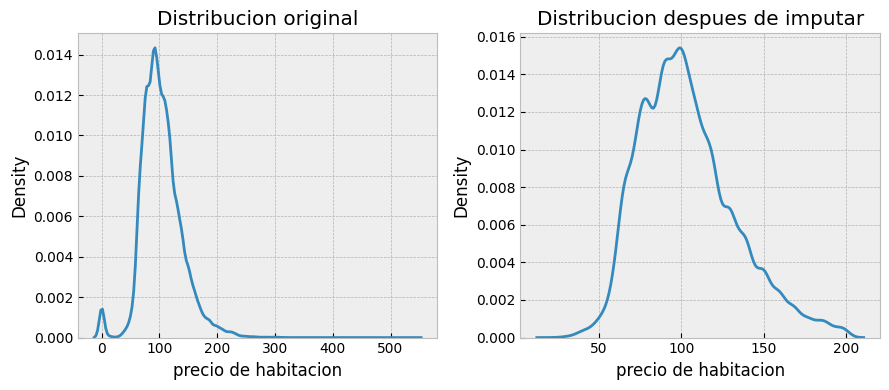

In [30]:
comparison_dist(df.avg_price_room, price, 'imputar', 'precio de habitacion', (9,4))

In [31]:
#SE REEMPLAZA LA VARIABLE DEL DATAFRAME PRINCIPAL POR LA SERIE CON VALORES IMPUTADOS
df.avg_price_room = price

#SE LIBERAN RECURSOS
del price

#INFO
df.avg_price_room.describe()

count    36133.000000
mean       103.483989
std         28.883167
min         23.000000
25%         81.080000
50%         99.480000
75%        120.000000
max        200.000000
Name: avg_price_room, dtype: float64

### Variable ***booking_status***

En esta seccion se modificará el nombre de la leyenda para los valores unicos de la variable de interes a fines descriptivos.

In [32]:
df.booking_status = df.booking_status.str.replace('Not_Canceled', 'No cancelada')
df.booking_status = df.booking_status.str.replace('Canceled', 'Cancelada')

### Variables cualitativas

En esta seccion se le da tratamiento a quellas variables que no son numericas. Para ello se utilizara la herramienta ***LabelEncoder*** destinado a las variables nominales, mientras que para las ordinales se lo hara respetando el orden inherente a su naturaleza. Aqui

In [33]:
#LISTA CON NOMBRE DE VARIABLES CUALITATIVAS
qualitative_var = [column for column in df.columns if df[column].dtype == 'object']
qualitative_var.remove('Booking_ID')
print(qualitative_var)

['meal_plan', 'room_type', 'arrival_season', 'mkt_segment', 'booking_status']


Para explorar el contenido de cada variable cualitativa se imprime us valores unicos para cada una de ellas

In [34]:
#VALORES UNICOS PARA CADA VARIABLE
for var in qualitative_var:
    print(f'{var}:')
    for item in df[var].unique():
        print(f'\t{item}')

meal_plan:
	Meal Plan 1
	Not Selected
	Meal Plan 2
	Meal Plan 3
room_type:
	Room_Type 1
	Room_Type 4
	Room_Type 6
	Room_Type 5
	Room_Type 2
	Room_Type 7
	Room_Type 3
arrival_season:
	winter
	spring
	autumn
	summer
mkt_segment:
	Offline
	Online
	Corporate
	Aviation
	Complementary
booking_status:
	No cancelada
	Cancelada


Conociendo mejor el contenido de las variables cualitativas, se decide crear las siguientes variables numericas:
- meal_plan_id
- room_type_id
- booking_status_id
- mkt_segment_id
- arrival_season_id

Cada una corresponde a una variable cualitativa pero conteniendo un codigo numerico correspondiente a cada valor unico de la variable. Para aquellas que son de naturaleza ordinal se asignan los valores cuantitativos de manera manual a fin de conservar el orden natural de la variable. Mientras que para las nominales se utilza ***LabelEncoder***.

In [35]:
#DATAFRAME COMPLEMENTARIO
df_qualitative = df[qualitative_var].copy()

#TRANSFORMACION VARIABLES ORDINALES
df_qualitative.loc[:,'meal_plan_cod'] = df_qualitative.meal_plan.apply(get_ordinal_var)
df_qualitative.meal_plan_cod = df_qualitative.meal_plan_cod.astype(int)

df_qualitative.loc[:,'room_type_cod'] = df_qualitative.room_type.apply(get_ordinal_var)
df_qualitative.room_type_cod = df_qualitative.room_type_cod.astype(int)

#TRANSFORMACION VARIABLES NOMINALES
encoder = LabelEncoder()
df_qualitative['mkt_segment_cod'] = encoder.fit_transform(df_qualitative.mkt_segment.values)
df_qualitative['arrival_season_cod'] = encoder.fit_transform(df_qualitative.arrival_season.values)

df_qualitative['booking_status_cod'] = df_qualitative['booking_status']
df_qualitative['booking_status_cod'] = df_qualitative['booking_status_cod'].str.replace('No cancelada','0')
df_qualitative['booking_status_cod'] = df_qualitative['booking_status_cod'].str.replace('Cancelada','1')
df_qualitative['booking_status_cod'] = df_qualitative['booking_status_cod'].astype(int)

#SE ELIMINAN LAS VARIABLES NO NECESARIAS
df_qualitative.drop(columns=qualitative_var, inplace=True)


df_qualitative.head()

,meal_plan_cod,room_type_cod,mkt_segment_cod,arrival_season_cod,booking_status_cod
0,1,1,3,3,0
1,0,1,4,1,0
2,1,1,4,1,1
3,1,1,4,1,1
4,0,1,4,0,1


Luego de crear las variables numericas se las insertan en el datafreme original

In [36]:
#CONCATENACION DE DATAFRAMES
df = pd.concat([df, df_qualitative], axis=1)

#SE LIBERAN RECURSOS
del df_qualitative

#INFO
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36133 entries, 0 to 36274
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Booking_ID              36133 non-null  object 
 1   num_adults              36133 non-null  int64  
 2   num_children            36133 non-null  int64  
 3   weekend_nights          36133 non-null  int64  
 4   week_nights             36133 non-null  int64  
 5   total_nights            36133 non-null  int64  
 6   meal_plan               36133 non-null  object 
 7   car_parking             36133 non-null  int64  
 8   room_type               36133 non-null  object 
 9   lead_time               36133 non-null  int64  
 10  arrival_year            36133 non-null  int64  
 11  arrival_month           36133 non-null  int64  
 12  arrival_day             36133 non-null  int64  
 13  arrival_season          36133 non-null  object 
 14  mkt_segment             36133 non-null  obj

## EDA

### Analisis de correlaciones

En esta seccion perteneciente al ***EDA*** se analizaran las correlaciones de todas las variables contra la variable objetivo ***booking_status_id***, esta representa la dicotomia de la variable ***booking_status*** de manera numerica para poder utilizar los metodos de correlacion.

#### Separacion de variables segun su tipo

In [37]:
numeric_var = ['num_adults', 'num_children', 'weekend_nights','week_nights',
                'total_nights', 'lead_time','num_prev_cancellations',
                'num_prev_not_canceled', 'avg_price_room', 'num_sp_requests']

nominal_var = ['repeated_guest', 'car_parking', 'arrival_season_cod', 'mkt_segment_cod']

ordinal_var = ['meal_plan_cod','room_type_cod']

#### Matriz de correlacion (Pearson)

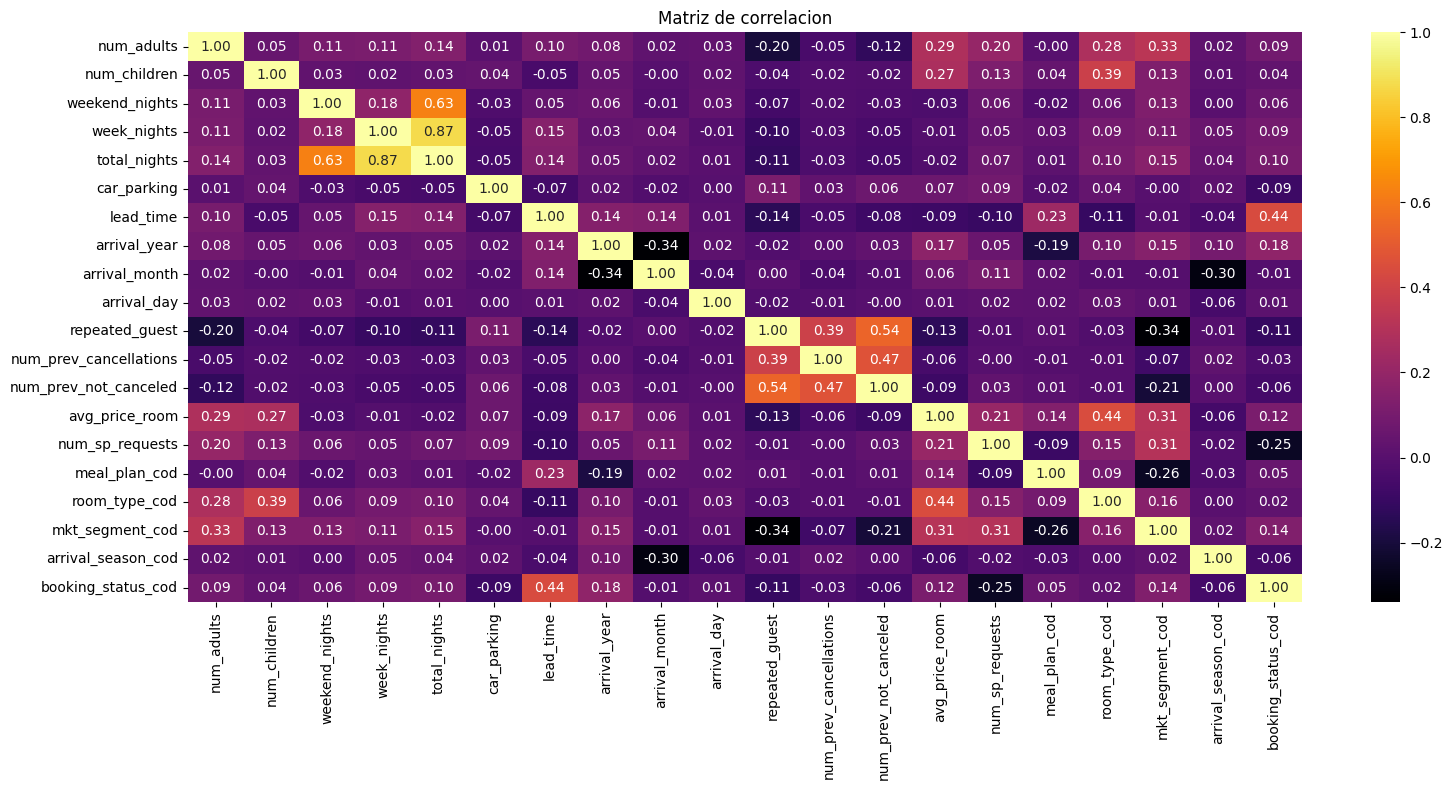

In [38]:
matrix = df.corr(numeric_only=True)
plt.figure(figsize=(16,8))
sns.heatmap(matrix, fmt='.2f', annot=True, cmap='inferno')
plt.title('Matriz de correlacion')
plt.tight_layout()
plt.show()

#### Correlacion de variable ***booking_status*** con variables cuantitativas y ordinales

Se utiliza el ***coeficiente de correlacion punto biserial*** para determinar la relacion entre las variables cuantitativas y la variable de interes ***booking_status*** que es de tipo nominal dicotomica.

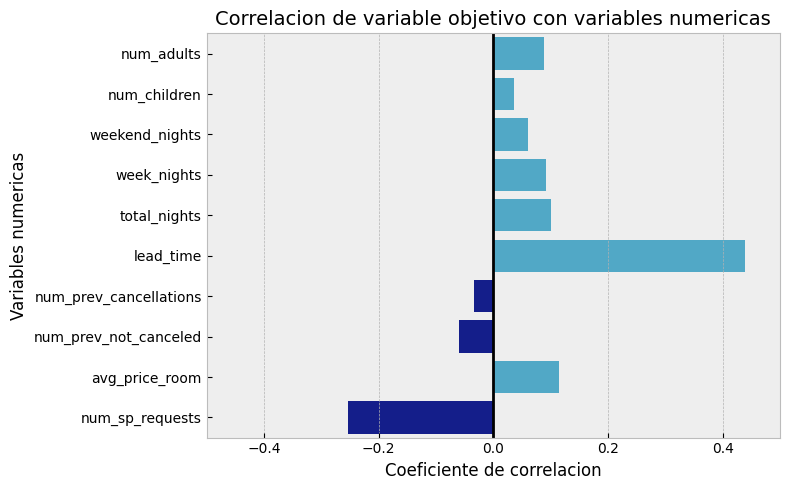

In [39]:
PlotCorrelation(df, 'booking_status_cod', numeric_var, 'numericas').plot_biserial_point()

#### Correlacion de variable objetivo ***booking_status*** con variables de origen nominal

Se utiliza la ***coeficiente de contingencia*** para determinar la relacion entre las variables nominales y la variable de interes ***booking_status*** que es de tipo nominal dicotomica. Para ello se obtiene el estadisitico de prueba ***Chi cuadrado*** utilizando la libreria ***scipy*** para posteriormente obtener el coeficiente con la formula que se muestra acontinuacion:
$$
C = \sqrt{\frac{x^2}{N+x^2}}
$$
X²: Estadistico Chi²<br>
N: Cantidadad de observaciones totales<br>
C: coeficiente de contingencia<br>

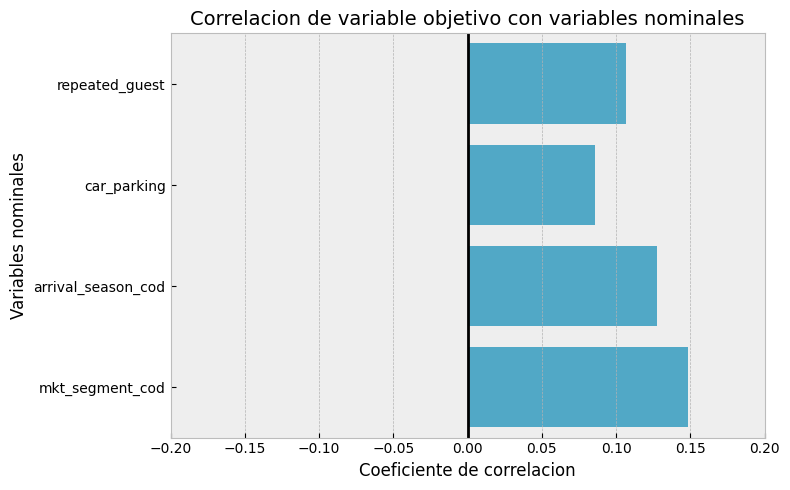

In [40]:
PlotCorrelation(df, 'booking_status_cod', nominal_var, 'nominales').plot_coef_contingency()

### Graficos de exploracion

#### Comportamiento de la reservas

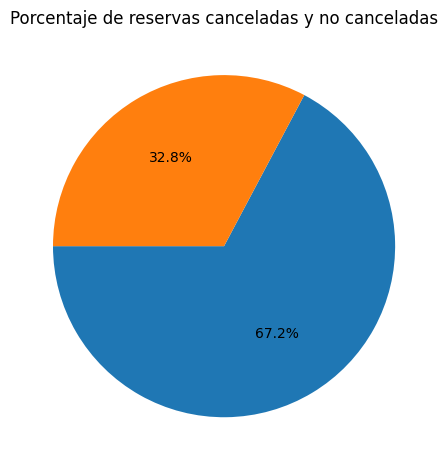

In [41]:
#GRAFICO DE TORTA RESERVAS CANCELADAS Y NO CANCELADAS
count = df.booking_status.value_counts()
plt.pie(count, autopct='%1.1f%%', startangle=180)
plt.title('Porcentaje de reservas canceladas y no canceladas')

plt.tight_layout()
plt.show()

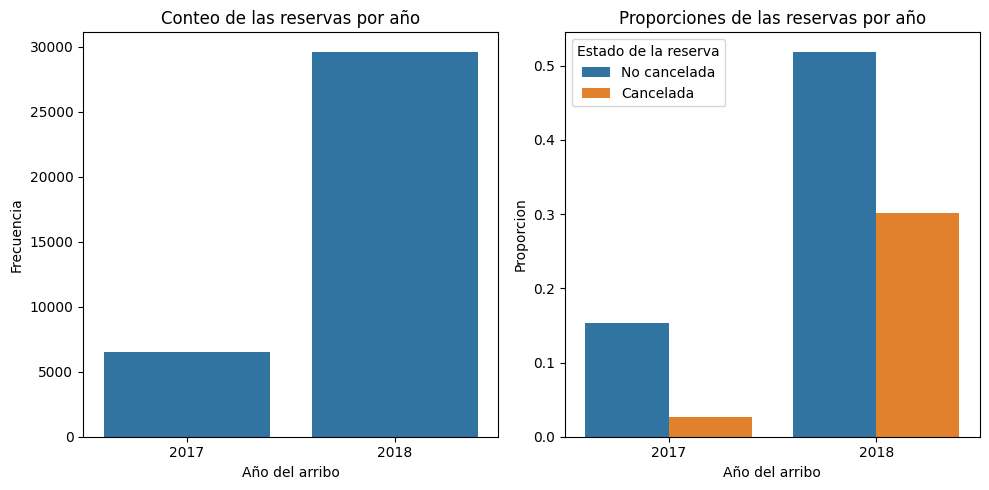

In [42]:
#COMPORTAMIENTO ANUAL DE LAS RESERVAS
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.countplot(x=df.arrival_year,ax=ax[0])
ax[0].set_title('Conteo de las reservas por año')
ax[0].set_xlabel('Año del arribo')
ax[0].set_ylabel('Frecuencia')

sns.countplot(x=df.arrival_year,hue=df.booking_status, stat='proportion', ax=ax[1])
ax[1].set_title('Proporciones de las reservas por año')
ax[1].set_xlabel('Año del arribo')
ax[1].set_ylabel('Proporcion')
ax[1].get_legend().set_title('Estado de la reserva')

plt.tight_layout()
plt.show()

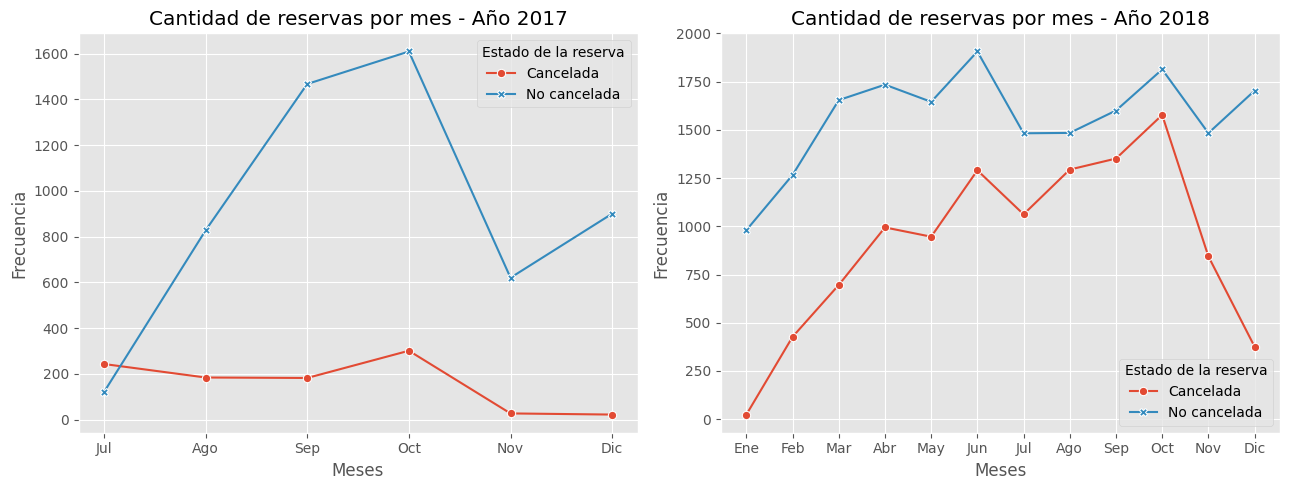

In [43]:
#COMPORTAMIENTO MENSUAL DE LAS RESERVAS
bookings = df.groupby(['arrival_year','arrival_month','booking_status'])['booking_status'].count().reset_index(name='count')
months = ['Ene','Feb','Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

#GRAFICO
mpl.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

#AÑO 2017
data=bookings.loc[bookings.arrival_year==2017]
sns.lineplot(data=data, x='arrival_month', y='count', hue='booking_status', ax=ax[0], style='booking_status', markers=True, dashes=False)
ax[0].set_title('Cantidad de reservas por mes - Año 2017')
ax[0].set_xlabel('Meses')
ax[0].set_xticks(ticks=data.arrival_month.unique(), labels=months[6:])
ax[0].set_ylabel('Frecuencia')
ax[0].get_legend().set_title('Estado de la reserva')

#AÑO 2018
data=bookings.loc[bookings.arrival_year==2018]
sns.lineplot(data=data, x='arrival_month', y='count', hue='booking_status', ax=ax[1], style='booking_status', markers=True, dashes=False)
ax[1].set_title('Cantidad de reservas por mes - Año 2018')
ax[1].set_xlabel('Meses')
ax[1].set_xticks(ticks=data.arrival_month.unique(), labels=months)
ax[1].set_ylabel('Frecuencia')
ax[1].get_legend().set_title('Estado de la reserva')

plt.tight_layout()
plt.show()
mpl.style.use('default')

#### Distribucion de la variable ***avg_price_room***

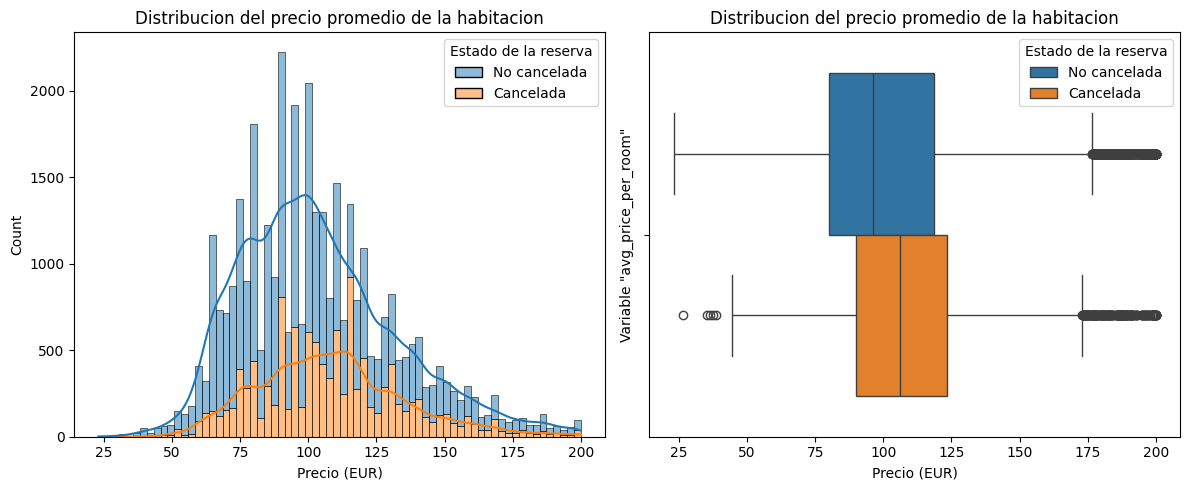

In [44]:
#DISTRIBUCION VARIABLE AVG_PRICE_ROOM
#mpl.style.use('bmh')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(x=df.avg_price_room, hue=df.booking_status, multiple='stack',bins=70, kde=True, ax=ax[0])
ax[0].set_title('Distribucion del precio promedio de la habitacion')
ax[0].set_xlabel('Precio (EUR)')
ax[0].get_legend().set_title('Estado de la reserva')

sns.boxplot(x=df.avg_price_room, hue=df.booking_status, ax=ax[1])
ax[1].set_title('Distribucion del precio promedio de la habitacion')
ax[1].set_xlabel('Precio (EUR)')
ax[1].set_ylabel('Variable "avg_price_per_room"')
ax[1].get_legend().set_title('Estado de la reserva')
plt.tight_layout()
plt.show()

#### Distribucion de la variable ***lead_time***

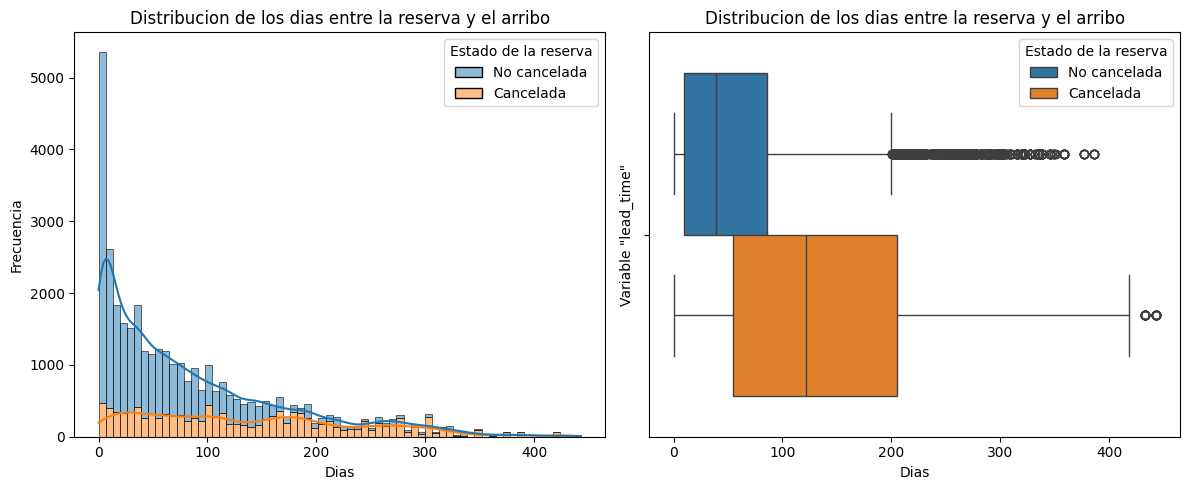

In [45]:
#DISTRIBUCION VARIABLE AVG_PRICE_ROOM
#mpl.style.use('bmh')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(x=df.lead_time, hue=df.booking_status, multiple='stack', kde=True, ax=ax[0])
ax[0].set_title('Distribucion de los dias entre la reserva y el arribo')
ax[0].set_xlabel('Dias')
ax[0].set_ylabel('Frecuencia')
ax[0].get_legend().set_title('Estado de la reserva')

sns.boxplot(x=df.lead_time, hue=df.booking_status, ax=ax[1])
ax[1].set_title('Distribucion de los dias entre la reserva y el arribo')
ax[1].set_xlabel('Dias')
ax[1].set_ylabel('Variable "lead_time"')
ax[1].get_legend().set_title('Estado de la reserva')
plt.tight_layout()
plt.show()

#### Distribucion de la variable ***num_sp_requests***

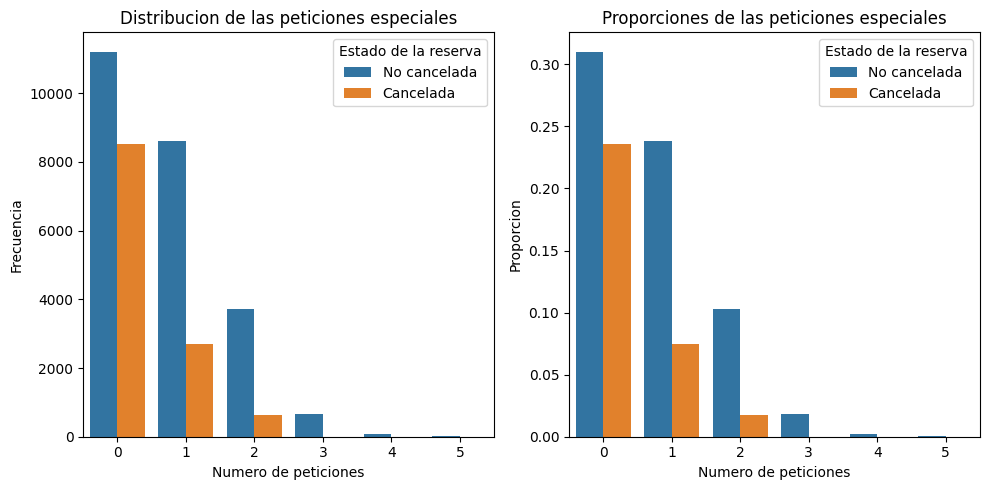

In [46]:
#DISTRIBUCION DE LAS PETICIONES ESPECIALES
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.countplot(x=df.num_sp_requests,ax=ax[0], hue=df.booking_status)
ax[0].set_title('Distribucion de las peticiones especiales')
ax[0].set_xlabel('Numero de peticiones')
ax[0].set_ylabel('Frecuencia')
ax[0].get_legend().set_title('Estado de la reserva')

sns.countplot(x=df.num_sp_requests,hue=df.booking_status, stat='proportion', ax=ax[1])
ax[1].set_title('Proporciones de las peticiones especiales')
ax[1].set_xlabel('Numero de peticiones')
ax[1].set_ylabel('Proporcion')
ax[1].get_legend().set_title('Estado de la reserva')

plt.tight_layout()
plt.show()

#### Distribucion de la variable ***mkt_segment***

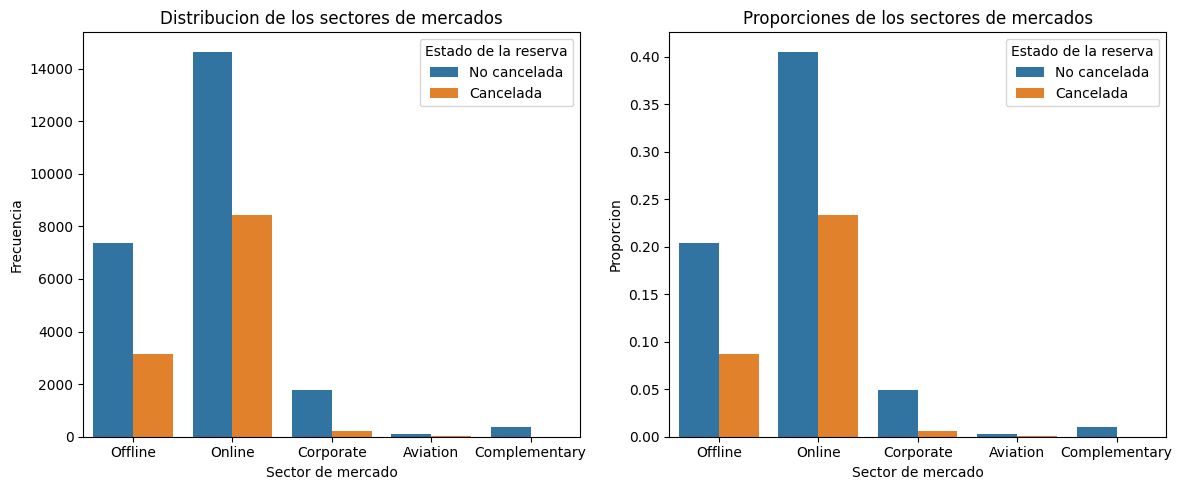

In [47]:
#DISTRIBUCION DE LOS SECTORES DE MERCADO
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.countplot(x=df.mkt_segment,ax=ax[0], hue=df.booking_status)
ax[0].set_title('Distribucion de los sectores de mercados')
ax[0].set_xlabel('Sector de mercado')
ax[0].set_ylabel('Frecuencia')
ax[0].get_legend().set_title('Estado de la reserva')

sns.countplot(x=df.mkt_segment,hue=df.booking_status, stat='proportion', ax=ax[1])
ax[1].set_title('Proporciones de los sectores de mercados')
ax[1].set_xlabel('Sector de mercado')
ax[1].set_ylabel('Proporcion')
ax[1].get_legend().set_title('Estado de la reserva')

plt.tight_layout()
plt.show()

#### Analisis bivariado: ***lead_time*** vs ***avg_price_room*** 

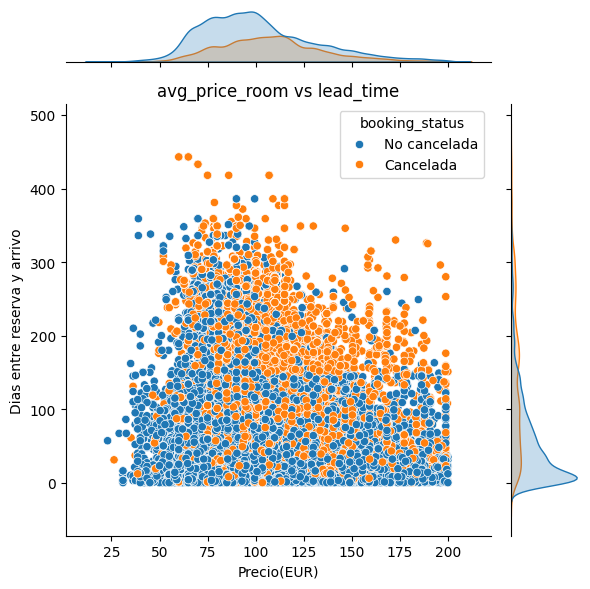

In [48]:
#GRAFICO DE RELACION ENTRE VARIABLES AVG_PRICE_ROOM Y LEAD_TIME
sns.jointplot(y=df.lead_time, x=df.avg_price_room, hue=df.booking_status)
plt.title('avg_price_room vs lead_time')
plt.xlabel('Precio(EUR)')
plt.ylabel('Dias entre reserva y arrivo')
plt.tight_layout()
plt.show()

#### Analisis bivariado: ***lead_time*** vs ***num_sp_requests***

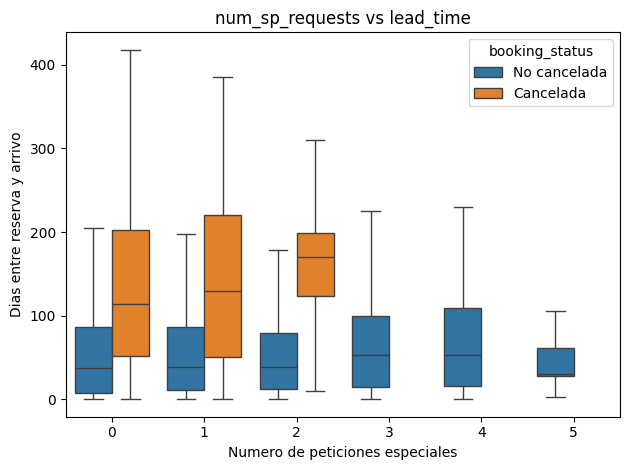

In [49]:
sns.boxplot(y=df.lead_time, x=df.num_sp_requests, hue=df.booking_status, showfliers=False)
plt.title('num_sp_requests vs lead_time')
plt.xlabel('Numero de peticiones especiales')
plt.ylabel('Dias entre reserva y arrivo')
plt.tight_layout()
plt.show()

#### Analisis bivariado: ***lead_time*** vs ***mkt_segment***

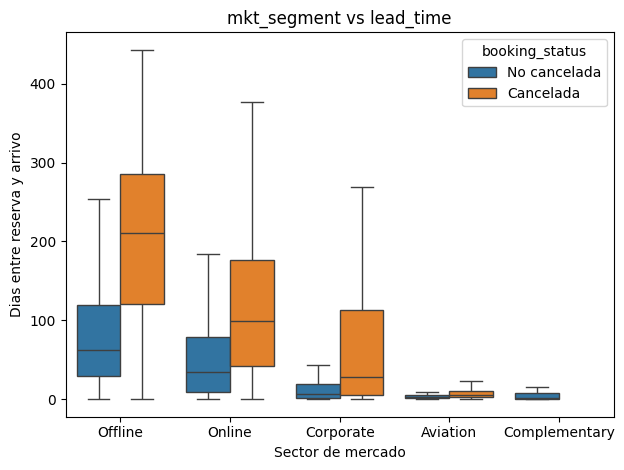

In [50]:
sns.boxplot(y=df.lead_time, x=df.mkt_segment, hue=df.booking_status, showfliers=False)
plt.title('mkt_segment vs lead_time')
plt.xlabel('Sector de mercado')
plt.ylabel('Dias entre reserva y arrivo')
plt.tight_layout()
plt.show()

#### Analisis multivariado

En este grafico se pueden divisar la ubicacion en el espacion de los puntos en relacion a las 3 variables insight, tambien es ligeramente visible cierta agrupacion de las reservas canceladas.

In [51]:
fig = px.scatter_3d(df, x='avg_price_room', y='lead_time', z='num_sp_requests', color='booking_status')

fig.update_layout(title='Precio pormedio VS Dias entre reserva y arrivo VS Peticiones especiales',
                  xaxis_title='Mes',
                  yaxis_title='Conteo',
                  showlegend=True,
                  legend_title_text='Estado de la reserva',
                  scene=dict(
                      xaxis=dict(title='Precio promedio por habitación'),
                      yaxis=dict(title='Días entre reserva y llegada'),
                      zaxis=dict(title='Número de peticiones especiales')
                  ),
                  width=850,
                  height=750)

fig.show()